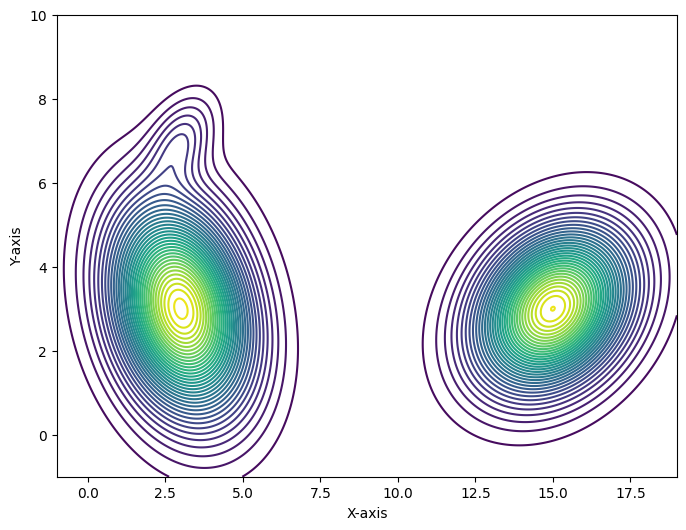

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# define distribution 2

mean11 = [3, 7]
cov11 = [[0.5, 0.2], [0.2, 0.5]]
weight11 = 0.03

mean12 = [3, 3]
cov12 = [[2, -0.5], [-0.5, 2.5]]
weight12 = 1 - weight11

weight1 = [weight11, weight12]

x, y = np.meshgrid(np.linspace(-1, 10, 400), np.linspace(-1, 10, 400))
pos = np.dstack((x, y))


rv1 = multivariate_normal(mean11, cov11)
rv2 = multivariate_normal(mean12, cov12)

z1 = weight1[0] * rv1.pdf(pos) + weight1[1] * rv2.pdf(pos)



# distribution 1
mean2 = [15, 3]
cov2 = [[2.5, 0.5], [0.5, 1.5]]
x2, y2 = np.meshgrid(np.linspace(3, 19, 400), np.linspace(-1, 10, 400))

pos = np.dstack((x2, y2))

rv = multivariate_normal(mean2, cov2)

z2 = rv.pdf(pos)
# Plot the contour
plt.figure(figsize=(8, 6))
plt.contour(x, y, z1, levels=40, cmap='viridis')
plt.contour(x2, y2, z2, levels=40, cmap='viridis')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
# plt.xlim(0, 25)
# plt.ylim(0, 25)
#plt.colorbar(label='Density')
plt.show()


In [10]:
import torch

MEAN_2 = torch.tensor(mean2, dtype=torch.float)
SIGMA_2 = torch.tensor(cov2, dtype=torch.float)

SIGMA_11 = torch.tensor(cov11, dtype=torch.float)
SIGMA_12 = torch.tensor(cov12, dtype=torch.float)
MEAN11 = torch.tensor(mean11, dtype=torch.float)
MEAN12 = torch.tensor(mean12, dtype=torch.float)

MEAN_1 = MEAN11 * weight11 + MEAN12 * weight12
# MEAN_1
SIGMA_1 = weight11 * (SIGMA_11 + (MEAN11 - MEAN_1) @ (MEAN11 - MEAN_1).t()) + \
          weight12 * (SIGMA_12 + (MEAN12 - MEAN_1) @ (MEAN12 - MEAN_1).t())
SIGMA_1


tensor([[ 2.4206, -0.0134],
        [-0.0134,  2.9056]])

In [11]:
import utils as F



def compute_mean_SOUT(mean_list, sigma_list, tau=0.01):
    n = len(mean_list)
    dim = sigma_list[0].shape[1] 

    sigma_tau_list = [torch.eye(dim) + tau/2 * torch.linalg.inv(x) for x in sigma_list]
    
    M_list = []
    for i in range(len(mean_list)):
        M_list.append(
            (torch.norm(torch.linalg.inv(sigma_tau_list[i]), p=2) ** 2 + 1) * torch.eye(dim) \
            - 2 * torch.linalg.inv(sigma_tau_list[i]) \
            + tau/2 * torch.linalg.inv(sigma_tau_list[i]) @ torch.linalg.inv(sigma_list[i]) @ torch.linalg.inv(sigma_tau_list[i])
        )

    
    MEAN_B = torch.linalg.inv(sum(M_list)) @ sum([M_list[i] @ mean_list[i] for i in range(n)])

    return MEAN_B



# compute_mean_SOUT([MEAN_1, MEAN_2], [SIGMA_1, SIGMA_2])


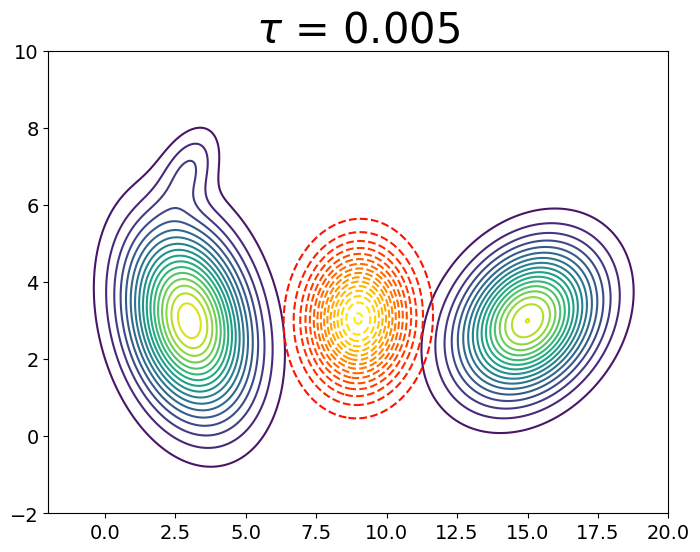

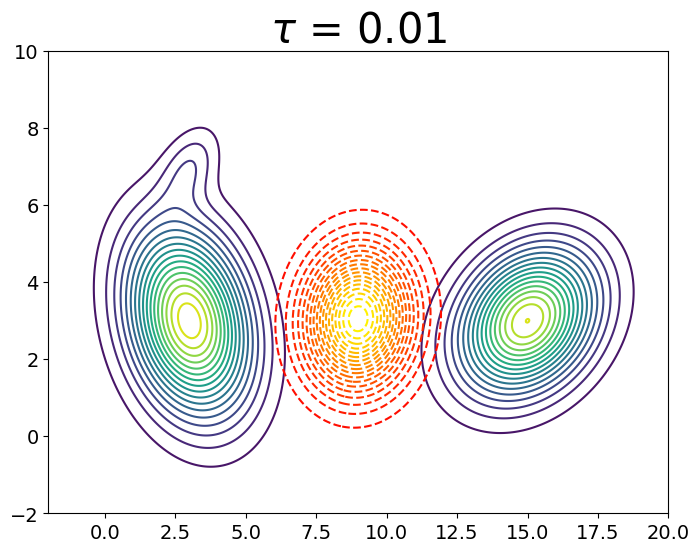

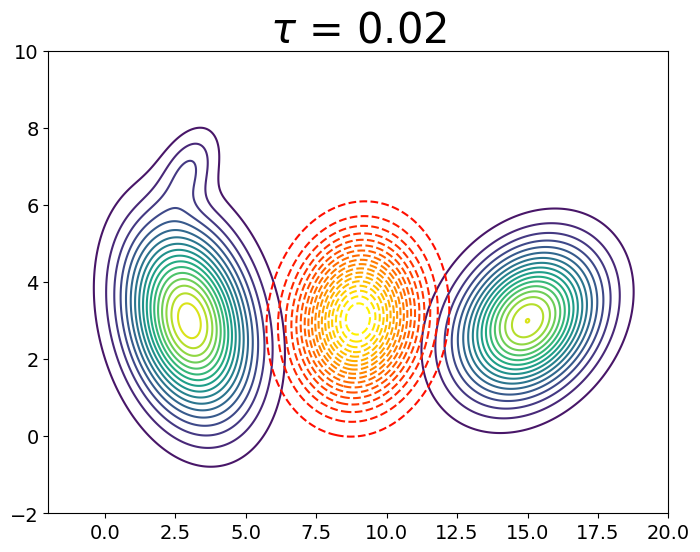

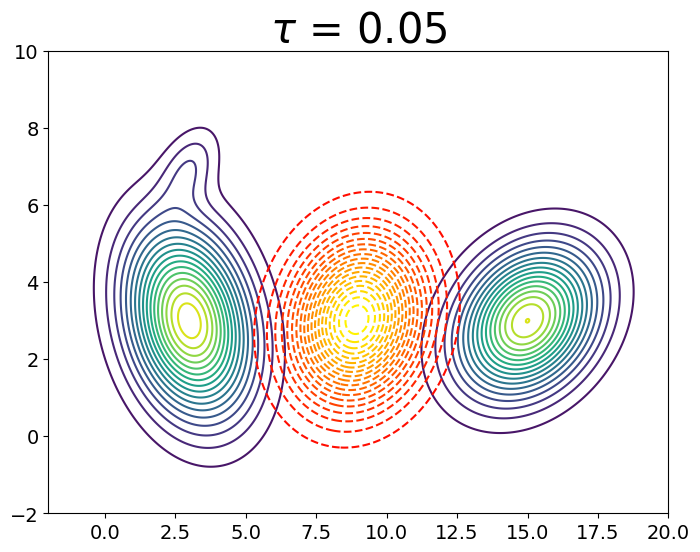

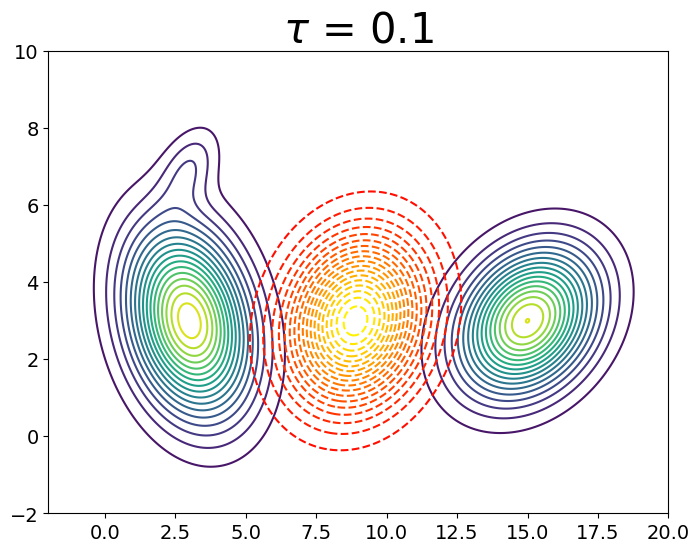

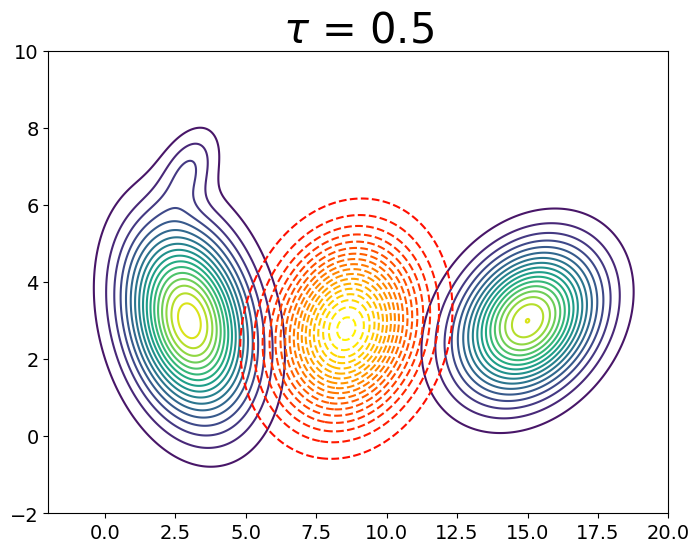

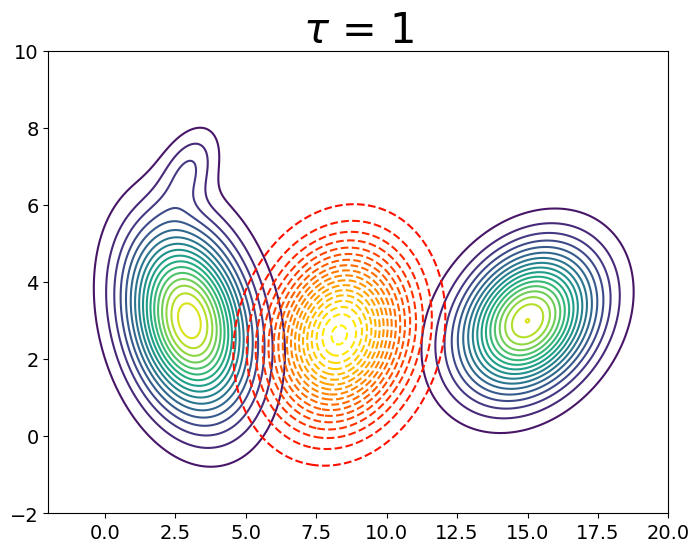

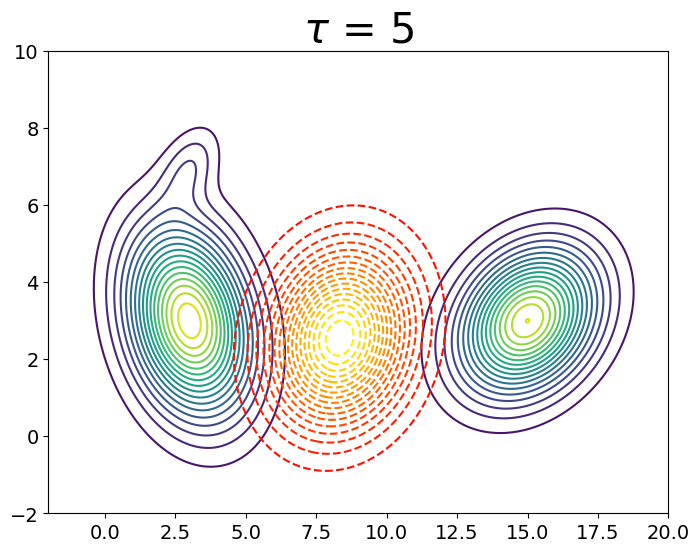

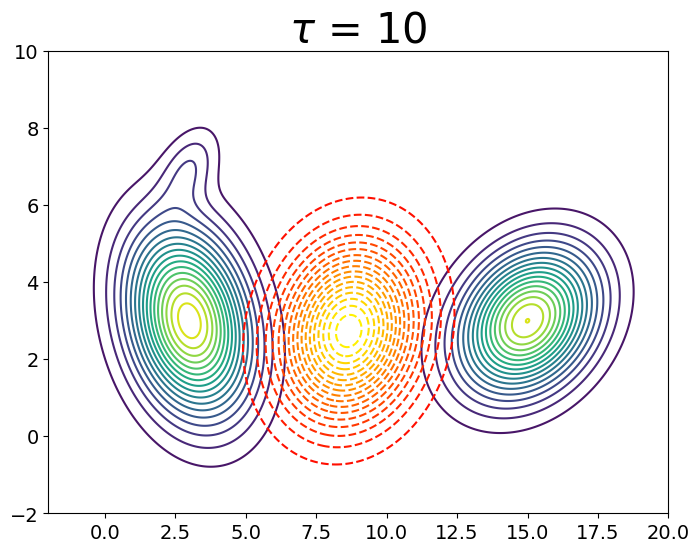

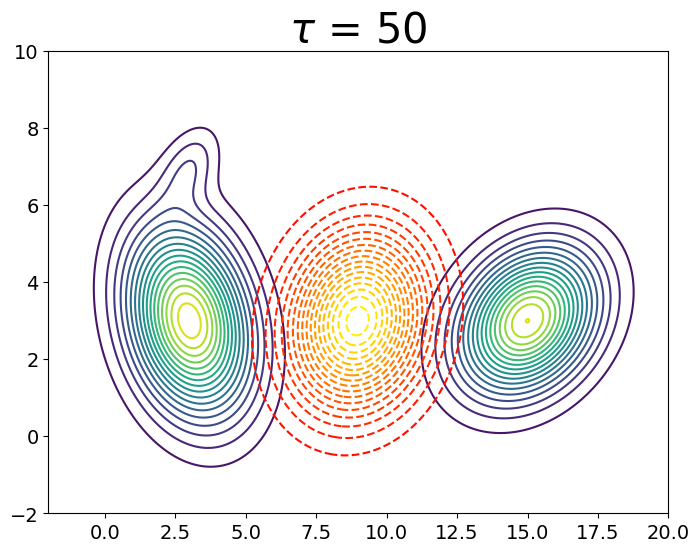

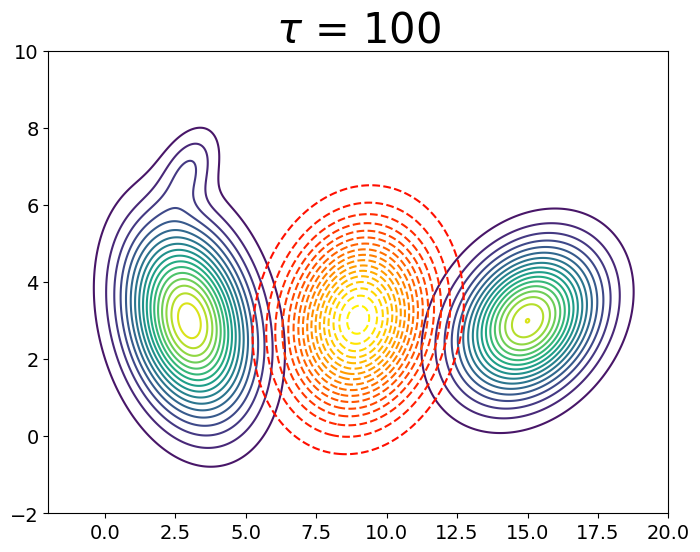

In [12]:
# distribution 1
x1, y1 = np.meshgrid(np.linspace(-2, 10, 400), np.linspace(-2, 10, 400))
pos = np.dstack((x1, y1))


rv1 = multivariate_normal(mean11, cov11)
rv2 = multivariate_normal(mean12, cov12)

z1 = weight1[0] * rv1.pdf(pos) + weight1[1] * rv2.pdf(pos)

#distribution 2
x2, y2 = np.meshgrid(np.linspace(3, 19, 400), np.linspace(-1, 10, 400))

pos = np.dstack((x2, y2))

rv = multivariate_normal(mean2, cov2)

z2 = rv.pdf(pos)

#barycenter
xb, yb = np.meshgrid(np.linspace(-2, 20, 400), np.linspace(-2, 20, 400))
pos = np.dstack((xb, yb))

tau_list = [0.005, 0.01, 0.02, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]

for tau in tau_list:
    MEAN_B = compute_mean_SOUT([MEAN_1, MEAN_2], [SIGMA_1, SIGMA_2], tau=tau)
    SIGMA_B = F.Bures_manifold_UOT_bary_hybridmethod(
        covariance_matrices=[SIGMA_1, SIGMA_2],
        Sigma_beta_0=torch.eye(2, dtype=torch.float),
        tau=tau
    )[0]
    rv = multivariate_normal(MEAN_B, SIGMA_B)
    zb = rv.pdf(pos)
    plt.figure(figsize=(8, 6))
    plt.contour(x1, y1, z1, levels=20, cmap = 'viridis')
    plt.contour(x2, y2, z2, levels=20, cmap = 'viridis')
    plt.contour(xb, yb, zb, levels=20, cmap = "autumn", linestyles = 'dashed')
    #plt.xlabel('X-axis')
    plt.ylim(-2, 10)
    plt.xticks(fontsize=14)  # Adjust fontsize as needed
    plt.yticks(fontsize=14)  # Adjust fontsize as needed
    plt.title(r"$\tau$ = {}".format(tau), fontsize = 30)  # Use raw string for LaTeX formatting
    plt.savefig(f"barycenter_tau_{tau}.png")
    plt.show()
    plt.close()

In [13]:
MEAN_TARGET = np.array([8.9892, 3.0535]) #Change to your true mean
SIGMA_TARGET = np.array([[1.4739, 0.0695],[0.0695, 1.3670]]) #Change to your true covariance


SIGMA_TARGET = torch.tensor(SIGMA_TARGET, dtype=torch.float32)
MEAN_TARGET = torch.tensor(MEAN_TARGET, dtype=torch.float32)


tau_list = np.linspace(0.02, 10, 500)

track = []

for tau in tau_list:
    MEAN_B = compute_mean_SOUT([MEAN_1, MEAN_2], [SIGMA_1, SIGMA_2], tau=tau)
    SIGMA_B = F.Bures_manifold_UOT_bary_hybridmethod(
        covariance_matrices=[SIGMA_1, SIGMA_2],
        Sigma_beta_0=torch.eye(2, dtype=torch.float),
        tau=tau
    )[0]
    MEAN_B = torch.tensor(MEAN_B, dtype=torch.float32)
    SIGMA_B = torch.tensor(SIGMA_B, dtype=torch.float32)
    distance = F.OT_distance(SIGMA_TARGET, SIGMA_B) + np.linalg.norm(MEAN_TARGET - MEAN_B)
    track.append(distance)

'\nMEAN_TARGET = np.array([8.9892, 3.0535])\nSIGMA_TARGET = np.array([[1.4739, 0.0695],[0.0695, 1.3670]])\n\n\nSIGMA_TARGET = torch.tensor(SIGMA_TARGET, dtype=torch.float32)\nMEAN_TARGET = torch.tensor(MEAN_TARGET, dtype=torch.float32)\n\n\ntau_list = np.linspace(0.02, 10, 500)\n\ntrack = []\n\nfor tau in tau_list:\n    MEAN_B = compute_mean_SOUT([MEAN_1, MEAN_2], [SIGMA_1, SIGMA_2], tau=tau)\n    SIGMA_B = F.Bures_manifold_UOT_bary_hybridmethod(\n        covariance_matrices=[SIGMA_1, SIGMA_2],\n        Sigma_beta_0=torch.eye(2, dtype=torch.float),\n        tau=tau\n    )[0]\n    MEAN_B = torch.tensor(MEAN_B, dtype=torch.float32)\n    SIGMA_B = torch.tensor(SIGMA_B, dtype=torch.float32)\n    distance = F.OT_distance(SIGMA_TARGET, SIGMA_B) + np.linalg.norm(MEAN_TARGET - MEAN_B)\n    track.append(distance)\n'

In [ ]:
SIGMA_TARGET = np.array([[1.4739, 0.0695],[0.0695, 1.3670]])


SIGMA_TARGET = torch.tensor(SIGMA_TARGET, dtype=torch.float32)
MEAN_TARGET = torch.tensor(MEAN_TARGET, dtype=torch.float32)


tau_list = np.linspace(0.02, 10, 500)

track = []

for tau in tau_list:
    MEAN_B = compute_mean_SOUT([MEAN_1, MEAN_2], [SIGMA_1, SIGMA_2], tau=tau)
    SIGMA_B = F.Bures_manifold_UOT_bary_hybridmethod(
        covariance_matrices=[SIGMA_1, SIGMA_2],
        Sigma_beta_0=torch.eye(2, dtype=torch.float),
        tau=tau
    )[0]
    MEAN_B = torch.tensor(MEAN_B, dtype=torch.float32)
    SIGMA_B = torch.tensor(SIGMA_B, dtype=torch.float32)
    distance = F.OT_distance(SIGMA_TARGET, SIGMA_B) + np.linalg.norm(MEAN_TARGET - MEAN_B)
    track.append(distance)

In [14]:
# Visualize the track
plt.figure(figsize=(12, 8))
plt.plot(tau_list, track, marker='o', linestyle='-', color='crimson')
plt.xlabel(r'$\tau$', fontsize = 18)
plt.ylabel('Bures-Wasserstein Distance', fontsize = 18)
#plt.title(r'Track of Distance vs $\tau$')
plt.grid(True)
plt.savefig(f"tracking_tau(to target).png")
plt.show()

'\n# Visualize the track\nplt.figure(figsize=(12, 8))\nplt.plot(tau_list, track, marker=\'o\', linestyle=\'-\', color=\'crimson\')\nplt.xlabel(r\'$\tau$\', fontsize = 18)\nplt.ylabel(\'Bures-Wasserstein Distance\', fontsize = 18)\n#plt.title(r\'Track of Distance vs $\tau$\')\nplt.grid(True)\nplt.savefig(f"tracking_tau(to target).png")\nplt.show()\n'

In [15]:
# Open a file in write mode
with open('tracking_data_target.txt', 'w') as file:
    # Write a header line
    file.write('tau_list track\n')
    
    # Iterate over the lists and write each line
    for tau, value in zip(tau_list, track):
        file.write(f'{tau:.5f} {value:.5f}\n')

"\n# Open a file in write mode\nwith open('tracking_data_target.txt', 'w') as file:\n    # Write a header line\n    file.write('tau_list track\n')\n    \n    # Iterate over the lists and write each line\n    for tau, value in zip(tau_list, track):\n        file.write(f'{tau:.5f} {value:.5f}\n')\n"

In [16]:
# Initialize lists
tau_list = []
track = []

# Read the data from the file
with open('tracking_data_target.txt', 'r') as file:
    next(file)  # Skip the header line
    for line in file:
        tau, value = map(float, line.split())
        tau_list.append(tau)
        track.append(value)

# Visualize the track
plt.figure(figsize=(12, 8))
plt.plot(tau_list, track, marker='o', linestyle='-', color='crimson')
plt.xlabel(r'$\tau$', fontsize = 18)
plt.ylabel('Bures-Wasserstein Distance', fontsize = 18)
plt.xticks(fontsize=20)  # Adjust fontsize as needed
plt.yticks(fontsize=20)  # Adjust fontsize as needed
#plt.title(r'Track of Distance vs $\tau$')
plt.grid(True)
plt.savefig(f"tracking_tau(to target).png")
plt.show()

'\n# Initialize lists\ntau_list = []\ntrack = []\n\n# Read the data from the file\nwith open(\'tracking_data_target.txt\', \'r\') as file:\n    next(file)  # Skip the header line\n    for line in file:\n        tau, value = map(float, line.split())\n        tau_list.append(tau)\n        track.append(value)\n\n# Visualize the track\nplt.figure(figsize=(12, 8))\nplt.plot(tau_list, track, marker=\'o\', linestyle=\'-\', color=\'crimson\')\nplt.xlabel(r\'$\tau$\', fontsize = 18)\nplt.ylabel(\'Bures-Wasserstein Distance\', fontsize = 18)\nplt.xticks(fontsize=20)  # Adjust fontsize as needed\nplt.yticks(fontsize=20)  # Adjust fontsize as needed\n#plt.title(r\'Track of Distance vs $\tau$\')\nplt.grid(True)\nplt.savefig(f"tracking_tau(to target).png")\nplt.show()\n'